# Brisbane VPR Event Reader with Position

In [1]:
import pynmea2
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
# Taken from https://github.com/Tobias-Fischer/ensemble-event-vpr/blob/master/read_gps.py
def get_gps(nmea_file_path):
    nmea_file = open(nmea_file_path, encoding='utf-8')

    latitudes, longitudes, timestamps = [], [], []

    first_timestamp = None
    previous_lat, previous_lon = 0, 0

    for line in nmea_file.readlines():
        try:
            msg = pynmea2.parse(line)
            if first_timestamp is None:
                first_timestamp = msg.timestamp
            if msg.sentence_type not in ['GSV', 'VTG', 'GSA']:
                # print(msg.timestamp, msg.latitude, msg.longitude)
                # print(repr(msg.latitude))
                dist_to_prev = np.linalg.norm(np.array([msg.latitude, msg.longitude]) - np.array([previous_lat, previous_lon]))
                if msg.latitude != 0 and msg.longitude != 0 and msg.latitude != previous_lat and msg.longitude != previous_lon and dist_to_prev > 0.0001:
                    timestamp_diff = (msg.timestamp.hour - first_timestamp.hour) * 3600 + (msg.timestamp.minute - first_timestamp.minute) * 60 + (msg.timestamp.second - first_timestamp.second)
                    latitudes.append(msg.latitude); longitudes.append(msg.longitude); timestamps.append(timestamp_diff)
                    previous_lat, previous_lon = msg.latitude, msg.longitude

        except pynmea2.ParseError as e:
            # print('Parse error: {} {}'.format(msg.sentence_type, e))
            continue

    return np.array(np.vstack((latitudes, longitudes, timestamps))).T

In [3]:
nmeaPaths = [
    "/media/geoffroy/T7/BrisbaneDataset/daytime/20200424_151015-daytime_concat.nmea",
    "/media/geoffroy/T7/BrisbaneDataset/morning/20200428_091154-morning_concat.nmea",
    "/media/geoffroy/T7/BrisbaneDataset/night/20200427_181204-night_concat.nmea",
    "/media/geoffroy/T7/BrisbaneDataset/sunrise/20200429_061912-sunrise_concat.nmea",
    "/media/geoffroy/T7/BrisbaneDataset/sunset1/20200421_170039-sunset1_concat.nmea",
    "/media/geoffroy/T7/BrisbaneDataset/sunset2/20200422_172431-sunset2_concat.nmea",
]

nmeaPaths = [
    "/mnt/e/BrisbaneDataset/daytime/20200424_151015-daytime_concat.nmea",
    "/mnt/e/BrisbaneDataset/morning/20200428_091154-morning_concat.nmea",
    "/mnt/e/BrisbaneDataset/night/20200427_181204-night_concat.nmea",
    "/mnt/e/BrisbaneDataset/sunrise/20200429_061912-sunrise_concat.nmea",
    "/mnt/e/BrisbaneDataset/sunset1/20200421_170039-sunset1_concat.nmea",
    "/mnt/e/BrisbaneDataset/sunset2/20200422_172431-sunset2_concat.nmea",
]

In [4]:
coordinates = []
for nmea in nmeaPaths:
    coordinates.append(get_gps(nmea))

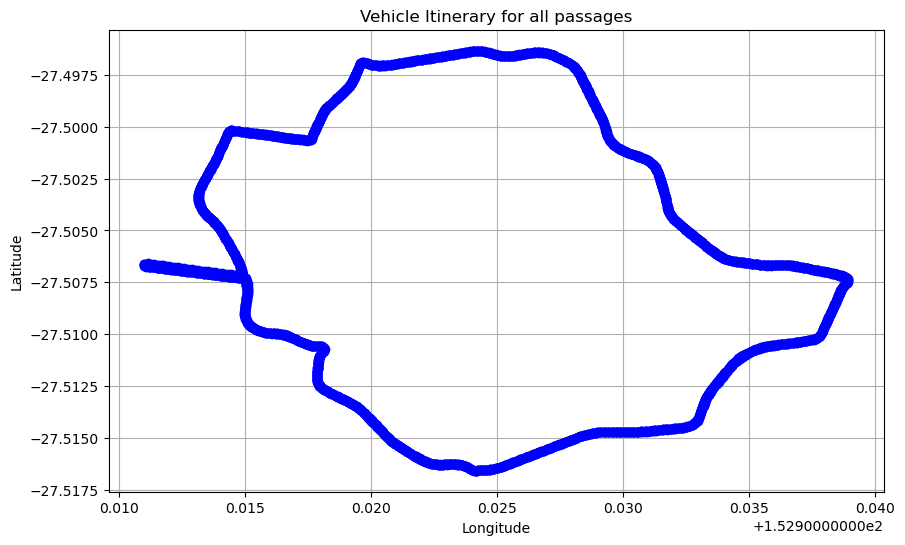

In [5]:
plt.figure(figsize=(10, 6))
for coordinate in coordinates:
    longitudes = coordinate.T[1]
    latitudes = coordinate.T[0]
    
   
    plt.plot(longitudes, latitudes, marker='o', linestyle='-', color='b')
    plt.title('Vehicle Itinerary for all passages')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)

# Select a random place and see selected events with temporal window = 1s

In [15]:
def getDistanceFromLatLongKm(lat1, lon1, lat2, lon2):
    '''
    Distance calculation between lat/long coordinates
    Haversine Formula
    with earth_radius = 6371km
    '''
    EARTH_RADIUS = 6371.

    #Convert lat long from degrees to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    # Differences in coordinates
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Haversine formula
    a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Distance in kilometers
    distance = EARTH_RADIUS * c
    return distance

def sampleItineraryFromDistance(latitudes: np.array, longitudes: np.array, samplingDistance:float) -> list:
    '''
    Sample itinerary points at a fixed sampling distance calculated through Haversine
    Returns list of sampled points
    '''
    index = 0
    distance = 0
    sampledPoints = []

    a = np.array([latitudes[0], longitudes[0]]) # Reference point
    b = np.array([latitudes[index], longitudes[index]])

    while index < len(latitudes) - 1: # While all the coordinates are not computed 
        while distance < samplingDistance: # Calculate the point b index where distance(a,b)=samplingDistance
            b = np.array([latitudes[index], longitudes[index]])
            distance = getDistanceFromLatLongKm(a[0], a[1], b[0], b[1])
                    
            if index < len(latitudes) - 1:
                index += 1
            else:
                print(f"Breaking at {index}")
                break
        a = b # Compute for the next point
        distance = 0
        sampledPoints.append(index)
    return sampledPoints

Breaking at 556


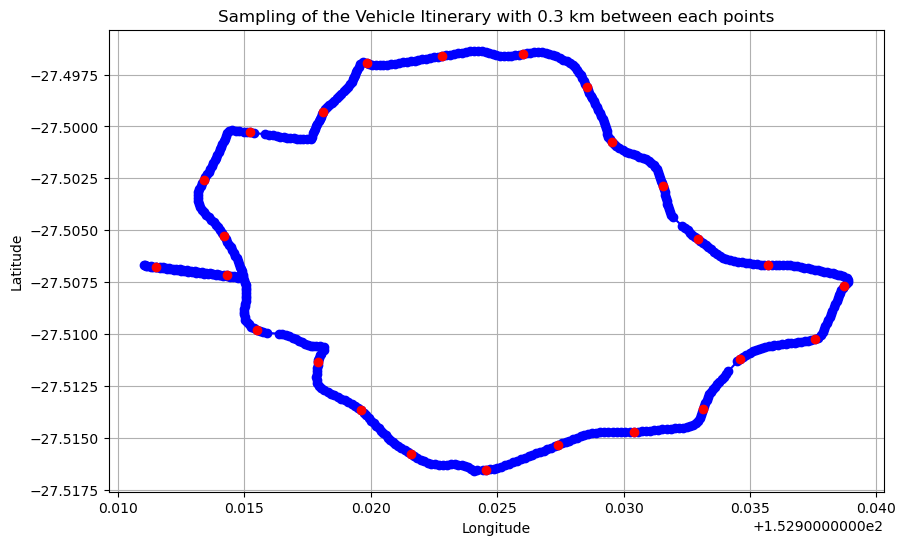

In [22]:
import random
SAMPLING_DISTANCE = 0.3
selectedPoint = random.randint(0, len(longitudes) - 1)
selectedPoint = 0

plt.figure(figsize=(10, 6))
longitudes = coordinates[0].T[1]
latitudes = coordinates[0].T[0]
timestamp = coordinates[0].T[2]

plt.plot(longitudes, latitudes, marker='o', linestyle='-', color='b')


sampledPoints = sampleItineraryFromDistance(latitudes, longitudes, SAMPLING_DISTANCE)
sampledPoints = sampledPoints[:-1] # Remove last point to avoid redundancy

for point in sampledPoints:
    plt.plot(longitudes[point], latitudes[point], marker='o', color='r')



plt.title(f'Sampling of the Vehicle Itinerary with {SAMPLING_DISTANCE} km between each points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()



In [8]:
video_beginning = {
    'sunset1': 1587452582.35,
    'sunset2': 1587540271.65,
    'daytime': 1587705130.80,
    'morning': 1588029265.73,
    'sunrise': 1588105232.91,
    'night': 1587975221.10
}

event_line_beginning = {
    'daytime': 2691668
}

In [9]:
import cv2

def readFrame(videoPath, index):
    vidObj = cv2.VideoCapture(videoPath)
    print(f"Video is at {vidObj.get(cv2.CAP_PROP_FPS)} fps")
    print(f"There are {vidObj.get(cv2.CAP_PROP_FRAME_COUNT)} frames in the recording")
    print(f"Around {vidObj.get(cv2.CAP_PROP_FRAME_COUNT) // 500} frames per timestamp")
    success = 0
    for image in range(index):
        success, image = vidObj.read()
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    if success:
        return image
    


In [10]:
def getEvents(eventsPath, spikeCount, startingLine) -> np.array:    
    index = 0
    lineIndex = 0
    
    with open(eventsPath) as fp:
        for line in fp:
            # DVS Dimension
            if index == 0:
                dim = line.strip('\n').split(' ')
                events = np.zeros((3, int(dim[0]), int(dim[1])))  # DVS Dimension is [346, 260]
                index += 1

            # If index is above the starting line, skip the line
            elif index < startingLine:
                index += 1
            else:
                # Slice the line and treat event info
                line = line.strip('\n').split(' ')
                
                x = int(line[1])
                y = int(line[2])
                time = round(float(line[0]), 2)
                
                if time - video_beginning["daytime"] >= 0:
                    if line[3] == '1':
                        events[0][x][y] += 1
                    else:
                        events[2][x][y] += 1
                    
                    if np.sum(events) == spikeCount // 2:
                        timestamp = round(float(line[0]), 2)
    

            # End reading when the spikeCount is achieved
            if np.sum(events) > spikeCount:
                break
            lineIndex += 1
    return events, timestamp
     


eventsPaths = ["/mnt/e/BrisbaneDataset/ensemble-event-vpr/output/dvs_vpr_2020-04-24-15-12-03.txt"]
spikeCount = 20000
startingLine = event_line_beginning['daytime']

events, timestamp = getEvents(eventsPaths[0], spikeCount, startingLine)


videoPath = "/mnt/e/BrisbaneDataset/daytime/20200424_151015-daytime_concat.mp4"
image = readFrame(videoPath, 1)


plt.figure()
plt.subplot(1,2,1)
plt.imshow(events.T, cmap="gray")
plt.title(f'Patten of event at {timestamp}')
plt.subplot(1,2,2)
plt.imshow(image)
plt.title(f'RGB Frame')

plt.tight_layout()
plt.show()


KeyboardInterrupt: 